In [1]:
import uproot
from uproot_methods import TLorentzVectorArray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.stats
import pyhf # limit computations
import pyhf.contrib.viz.brazil
pyhf.set_backend("numpy")
from scipy.optimize import toms748

In [2]:
def get_p4(tree, key):
    """
    Retrieve a 4-vector object from ROOT using the fCoordinates properties
    
    Necessary when reading ROOT files in via Uproot, since Uproot does not natively 
    recognize and convert LorentzVector objects
    """
    return TLorentzVectorArray.from_ptetaphim(
        tree[key]["fCoordinates.fPt"].array(),
        tree[key]["fCoordinates.fEta"].array(),
        tree[key]["fCoordinates.fPhi"].array(),
        tree[key]["fCoordinates.fM"].array(),
    )

In [3]:
def get_df(signal="vbshwwlvlvbb_c2v", lhe_rewgt_idx=-1):
    samples = [
        "tt1lpowheg", "tt2lpowheg", "ttw", "ttz", "raretop",
        "bosons", signal
    ]
    baby_dir = "/nfs-7/userdata/jguiang/VBSHWWBaby/v2.6_SS/v2/createMini_Run2"
    df = []
    for sample_path in glob.glob(f"{baby_dir}/*.root"):
        name = sample_path.split("/")[-1].split(".root")[0]
        if name not in samples:
            continue
        # Retrieve TTree
        with uproot.open(sample_path) as f:
            tree = f.get("variable")
            temp_df = tree.pandas.df(
                branches=["is_ps*", "wgt", "btagsf", "lepsf", 
                          "xsec_sf", "genrewgt", "trigsf", "pu_rewgt",
                          "drbb", "mbb", "mbbIn", "ptbb", 
                          "mjj", "detajj", "lt", "st"]
            )
            # Read in useful 4-vectors
            ld_lep_p4 = get_p4(tree, "leadlep")
            tr_lep_p4 = get_p4(tree, "subllep")
            # Set simple columns from 4-vectors
            temp_df["ld_lep_pt"] = ld_lep_p4.pt
            temp_df["tr_lep_pt"] = tr_lep_p4.pt
            # Compute additional columns
            temp_df["name"] = name
            temp_df["is_signal"] = (name == signal)
            temp_df["weight"] = (temp_df.wgt
                                 * temp_df.btagsf
                                 * temp_df.lepsf
                                 * temp_df.genrewgt
                                 * temp_df.trigsf
                                 * temp_df.pu_rewgt)
            # Apply sig-specific event weights
            if name == signal and lhe_rewgt_idx >= 0:
                temp_df["weight"] *= tree["lherewgts"].array()[:,lhe_rewgt_idx]
            # Apply bkg-specific event weights
            if name != signal:
                temp_df["weight"] *= temp_df.xsec_sf
            # Drop the columns we don't need
            temp_df.drop(
                columns=["wgt", "btagsf", "lepsf", "xsec_sf", "genrewgt", 
                         "trigsf", "pu_rewgt"], 
                inplace=True
            )
            df.append(temp_df)

    # Put dataframe together
    df = pd.concat(df)
    # Cast boolean-like columns to proper bools
    bool_like_cols = df.columns[df.columns.str.contains("is_")]
    df[bool_like_cols] = df[bool_like_cols].astype(bool)
    # Make sample col a categorical
    df["name"] = df.name.astype("category")
    return df

In [4]:
BASE_SEL = lambda df: (df.is_ps & df.mbbIn)
STRAWMAN_LEAD_EL = lambda df: (BASE_SEL(df) & df.is_ps_el)
STRAWMAN_LEAD_MU = lambda df: (BASE_SEL(df) & df.is_ps_mu)
STRAWMAN_LEP_TAU = lambda df: (BASE_SEL(df) & df.is_ps_tau)
STRAWMAN_NEG_NEG = lambda df: (BASE_SEL(df) & df.is_ps_neg)
STRAWMEN = lambda df: [
    ("mu+l+", STRAWMAN_LEAD_MU(df)),
    ("e+l+", STRAWMAN_LEAD_EL(df)),
    ("l+tau+", STRAWMAN_LEP_TAU(df)),
    ("lep-lep-", STRAWMAN_NEG_NEG(df))
]
STRAWMAN_LEP_LEP = lambda df: (BASE_SEL(df) & df.is_ps_lgt)

In [5]:
def get_limit_1bin(S, B, POI_val=1., all_results=True):
    if B <= 0:
        B = 1e-6
    model = pyhf.simplemodels.hepdata_like(
        signal_data=[S], bkg_data=[B], bkg_uncerts=[0.58*np.sqrt(B)]
    )
    data = [B] + model.config.auxdata
    # Get CL values (results) at mu = POI_val
    results = pyhf.infer.hypotest(POI_val, data, model, test_stat="qtilde", return_expected_set=True)
    if all_results:
        return results
    else:
        # Unpack results
        CL_obs, (CL_exp_m2sigma, CL_exp_m1sigma, CL_exp, CL_exp_p1sigma, CL_exp_p2sigma) = results
        return float(CL_exp)

def plot_limits_1bin(S, B, axes=None):
    if B <= 0:
        B = 1e-6
    model = pyhf.simplemodels.hepdata_like(
        signal_data=[S], bkg_data=[B], bkg_uncerts=[0.58*np.sqrt(B)]
    )
    data = [B] + model.config.auxdata

    POI_vals = np.linspace(0, 5, 41) # points of interest (mu)
    results = [
        pyhf.infer.hypotest(
            POI_val, data, model, test_stat="qtilde", return_expected_set=True
        )
        for POI_val in POI_vals
    ]

    if not axes:
        fig, axes = plt.subplots(figsize=(12, 9))
    return pyhf.contrib.viz.brazil.plot_results(axes, POI_vals, results)

def upperlimit_auto(data, model, low, high, level=0.05, atol=2e-12, rtol=1e-15,
                    obs_eq_exp=False):
    """
    Calculate an upper limit interval ``(0, poi_up)`` for a single
    Parameter of Interest (POI) using an automatic scan through
    POI-space, using the TOMS748 algorithm.

    ..., mostly copied from upperlimit docstring.
    """

    def f_all(mu):
        if high > 10:
            par_bounds=[(b[0], high) for b in model.config.suggested_bounds()]
        else:
            par_bounds=None
        return pyhf.infer.hypotest(
            mu, data, model, test_stat="qtilde", return_expected_set=True, par_bounds=par_bounds
        )

    def f(mu, limit=0):
        # Use integers for limit so we don't need a string comparison
        if limit == 0:
            # Obs
            return f_all(mu)[0] - level
        else:
            # Exp (These are in the order -2, -1, 0, 1, 2 sigma)
            return f_all(mu)[1][limit - 1] - level

    tb, _ = pyhf.get_backend()
    obs = tb.astensor(toms748(f, low, high, args=(0), k=2, xtol=atol, rtol=rtol))
    if obs_eq_exp:
        return float(obs)
    else:
        exp = [
            tb.astensor(toms748(f, low, high, args=(i), k=2, xtol=atol, rtol=rtol))
            for i in range(1, 6)
        ]
        return float(obs), exp

def figure_of_merit(sig_counts, bkg_counts, bkg_errors=[], obs_fluctuations=[], 
                    low=0.1, high=10000, tol=0.001):
    sig_counts = [S if S > 0 else 1e-6 for S in sig_counts]
    bkg_counts = [B if B > 0 else 1e-6 for B in bkg_counts]
    if len(bkg_errors) == 0:
        bkg_errors = [0.6*B for B in bkg_counts]
    model = pyhf.simplemodels.hepdata_like(
        signal_data=sig_counts,
        bkg_data=bkg_counts,
        bkg_uncerts=bkg_errors
    )
    if len(obs_fluctuations) == 0:
        obs_fluctuations = [0 for _ in bkg_counts]
    data = list(np.array(bkg_counts) + np.array(obs_fluctuations)) + model.config.auxdata
    try:
        return upperlimit_auto(
            data, model,
            low, high,
            level=0.05, atol=tol, rtol=tol,
            obs_eq_exp=True
        )
    except ValueError as e:
        print(f"WARNING: {e}")
        print(f"Defaulting to error-handling behaviour: returning {high}")
        return high

In [6]:
df = get_df(lhe_rewgt_idx=20)
df

,is_ps_el,is_ps_mu,is_ps_tau,is_ps_neg,is_ps_lgt,is_ps,drbb,mbb,mbbIn,ptbb,mjj,detajj,lt,st,ld_lep_pt,tr_lep_pt,name,is_signal,weight
entry,,,,,,,,,,,,,,,,,,,
0,True,False,False,False,True,True,0.497081,25.816963,1,96.786095,1677.664551,4.995605,377.597046,476.831421,71.288673,59.602882,bosons,False,0.000000
1,False,False,False,True,False,True,1.646614,61.345638,1,65.223434,1656.995117,6.392578,131.934128,201.871628,76.896477,49.550224,bosons,False,0.005594
2,False,False,False,True,False,True,3.262026,166.077347,0,213.228149,764.002808,4.472412,347.653442,602.747192,213.064819,54.376205,bosons,False,0.000000
3,False,True,False,False,True,True,0.523911,26.258171,1,80.480110,637.435974,4.725830,307.307098,388.275848,155.431534,133.147278,bosons,False,0.005536
4,False,True,False,False,True,True,2.596516,94.711746,1,51.146160,561.980103,3.693115,442.270935,546.724060,157.493271,57.744450,bosons,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,False,True,False,False,True,True,2.173155,176.771103,0,107.177139,640.312134,4.089355,412.150818,602.275818,233.326736,62.029068,ttz,False,0.001524
9167,False,False,True,False,False,True,3.277597,399.772156,0,18.825386,1315.938599,6.126709,371.359131,716.234131,246.159424,105.633408,ttz,False,0.001239
9168,False,True,False,False,True,True,3.269205,246.192139,0,84.842918,500.481903,3.401016,590.042236,728.135986,308.304474,163.965240,ttz,False,0.001301


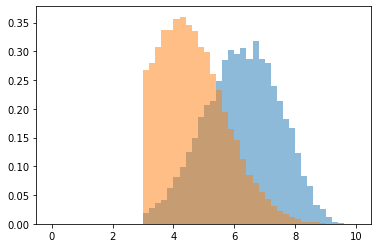

In [7]:
bins = np.linspace(0, 10, 51)

plt.hist(df[df.is_signal].detajj.abs(), bins=bins, density=True, alpha=0.5);
plt.hist(df[~df.is_signal].detajj.abs(), bins=bins, density=True, alpha=0.5);

In [8]:
# Heuristically chosen
standard_model_sr = "mbbIn and mjj > 1000 and detajj > 6" # (AND Mbb WINDOW IMPLICITLY!!)

rows = []
for name, channel in STRAWMEN(df):
    in_SM_sr = df.eval(standard_model_sr)
    sig_count = df[channel & in_SM_sr &  df.is_signal].weight.sum()
    bkg_count = df[channel & in_SM_sr & ~df.is_signal].weight.sum()
    rows.append({
        "channel": name,
        "region": standard_model_sr,
        "sig": sig_count,
        "bkg": bkg_count,
        "limit": figure_of_merit([sig_count], [bkg_count], low=10, high=5000.)
    })
    
table = pd.DataFrame(data=rows)
display(table)
print(table.to_csv(index=False))
print(figure_of_merit(table.sig.values, table.bkg.values, low=1, high=1000.))

Defaulting to error-handling behaviour: returning 5000.0


,channel,region,sig,bkg,limit
0,mu+l+,mbbIn and mjj > 1000 and detajj > 6,0.010712,0.898807,317.934510
1,e+l+,mbbIn and mjj > 1000 and detajj > 6,0.004199,0.799701,783.453766
2,l+tau+,mbbIn and mjj > 1000 and detajj > 6,0.000999,3.938567,5000.000000
3,lep-lep-,mbbIn and mjj > 1000 and detajj > 6,0.003466,4.782962,2025.615928


channel,region,sig,bkg,limit
mu+l+,mbbIn and mjj > 1000 and detajj > 6,0.010712210088968277,0.8988066911697388,317.93450989181406
e+l+,mbbIn and mjj > 1000 and detajj > 6,0.004199311137199402,0.7997008562088013,783.4537661502818
l+tau+,mbbIn and mjj > 1000 and detajj > 6,0.0009986407821998,3.9385671615600586,5000.0
lep-lep-,mbbIn and mjj > 1000 and detajj > 6,0.003466396825388074,4.782961845397949,2025.6159283242037

266.4304151656782


In [9]:
# Algorithmically chosen
standard_model_sr = "mjj >= 1740.0 and detajj >= 4.3" # (AND Mbb WINDOW IMPLICITLY!!)

rows = []
for name, channel in STRAWMEN(df):
    in_SM_sr = df.eval(standard_model_sr)
    sig_count = df[channel & in_SM_sr &  df.is_signal].weight.sum()
    bkg_count = df[channel & in_SM_sr & ~df.is_signal].weight.sum()
    rows.append({
        "channel": name,
        "region": standard_model_sr,
        "sig": sig_count,
        "bkg": bkg_count,
        "limit": figure_of_merit([sig_count], [bkg_count], low=1, high=3500.)
    })
    
table = pd.DataFrame(data=rows)
display(table)
print(table.to_csv(index=False))
print(figure_of_merit(table.sig.values, table.bkg.values, low=1, high=1000.))
print(figure_of_merit([table.sig.sum()], [table.bkg.sum()], low=1, high=1000.))

,channel,region,sig,bkg,limit
0,mu+l+,mjj >= 1740.0 and detajj >= 4.3,0.012707,0.656520,245.160309
1,e+l+,mjj >= 1740.0 and detajj >= 4.3,0.005367,0.593640,565.444794
2,l+tau+,mjj >= 1740.0 and detajj >= 4.3,0.001544,2.166403,3044.847062
3,lep-lep-,mjj >= 1740.0 and detajj >= 4.3,0.004233,2.377324,1157.447916


channel,region,sig,bkg,limit
mu+l+,mjj >= 1740.0 and detajj >= 4.3,0.012707210145890713,0.656519889831543,245.16030936185243
e+l+,mjj >= 1740.0 and detajj >= 4.3,0.00536737684160471,0.5936395525932312,565.4447938128428
l+tau+,mjj >= 1740.0 and detajj >= 4.3,0.0015440392307937145,2.166402816772461,3044.8470619283953
lep-lep-,mjj >= 1740.0 and detajj >= 4.3,0.004232726059854031,2.377323627471924,1157.4479156168527

195.38911620260194
330.1334005630198


In [10]:
# Algorithmically chosen and rounded
standard_model_sr = "mjj >= 1700.0 and detajj >= 4" # (AND Mbb WINDOW IMPLICITLY!!)

rows = []
for name, channel in STRAWMEN(df):
    in_SM_sr = df.eval(standard_model_sr)
    sig_count = df[channel & in_SM_sr &  df.is_signal].weight.sum()
    bkg_count = df[channel & in_SM_sr & ~df.is_signal].weight.sum()
    rows.append({
        "channel": name,
        "region": standard_model_sr,
        "sig": sig_count,
        "bkg": bkg_count,
        "limit": figure_of_merit([sig_count], [bkg_count], low=1, high=3500.)
    })
    
table = pd.DataFrame(data=rows)
display(table)
print(table.to_csv(index=False))
print(figure_of_merit(table.sig.values, table.bkg.values, low=1, high=1000.))
print(figure_of_merit([table.sig.sum()], [table.bkg.sum()], low=1, high=1000.))

,channel,region,sig,bkg,limit
0,mu+l+,mjj >= 1700.0 and detajj >= 4,0.012878,0.763799,252.137816
1,e+l+,mjj >= 1700.0 and detajj >= 4,0.005446,0.690019,579.713176
2,l+tau+,mjj >= 1700.0 and detajj >= 4,0.001587,2.325213,3056.175934
3,lep-lep-,mjj >= 1700.0 and detajj >= 4,0.004308,2.569732,1178.602099


channel,region,sig,bkg,limit
mu+l+,mjj >= 1700.0 and detajj >= 4,0.012878477573394775,0.7637991905212402,252.13781614746188
e+l+,mjj >= 1700.0 and detajj >= 4,0.0054458207450807095,0.6900191307067871,579.7131763985452
l+tau+,mjj >= 1700.0 and detajj >= 4,0.0015871378127485514,2.3252129554748535,3056.175934260098
lep-lep-,mjj >= 1700.0 and detajj >= 4,0.004307731986045837,2.569732427597046,1178.6020993765371

202.43158276148716
344.21183612362836


In [11]:
# Original BSM signal regions
base_bsm_sr = "detajj >= 5"
tight_bsm_sr = "lt >= 500 and st >= 900"
loose_bsm_sr = f"lt >= 300 and st >= 700 and not ({tight_bsm_sr})"
# 4 tight bins
rows = []
for name, channel in STRAWMEN(df):
    in_BSM_sr = df.eval(f"{base_bsm_sr} and {tight_bsm_sr}")
    sig_counts = df[channel & in_BSM_sr &  df.is_signal].weight.values
    bkg_counts = df[channel & in_BSM_sr & ~df.is_signal].weight.values
    rows.append({
        "channel": name,
        "region": f"{base_bsm_sr} and {tight_bsm_sr}",
        "sig": sig_counts.sum(),
        "sig_err": np.sqrt(np.sum(sig_counts**2)),
        "bkg": bkg_counts.sum(),
        "bkg_err": np.sqrt(np.sum(bkg_counts**2)),
        "limit": figure_of_merit([sig_counts.sum()], [bkg_counts.sum()], low=10, high=10000.)
    })
# 1 loose bin
in_BSM_sr = df.eval(f"{base_bsm_sr} and {loose_bsm_sr}")
sig_counts = df[STRAWMAN_LEP_LEP(df) & in_BSM_sr &  df.is_signal].weight.values
bkg_counts = df[STRAWMAN_LEP_LEP(df) & in_BSM_sr & ~df.is_signal].weight.values
rows.append({
    "channel": name,
    "region": f"{base_bsm_sr} and {tight_bsm_sr}",
    "sig": sig_counts.sum(),
    "sig_err": np.sqrt(np.sum(sig_counts**2)),
    "bkg": bkg_counts.sum(),
    "bkg_err": np.sqrt(np.sum(bkg_counts**2)),
    "limit": figure_of_merit([sig_counts.sum()], [bkg_counts.sum()], low=10, high=10000.)
})

table = pd.DataFrame(data=rows)
display(table)
print(table.to_csv(index=False))

bkg_stat_err = table.bkg_err.values
bkg_syst_err = 0.6*np.array(table.bkg.values)
bkg_errors = list(np.sqrt(bkg_syst_err**2 + bkg_stat_err**2))
print(figure_of_merit(table.sig.values, table.bkg.values, bkg_errors=bkg_errors, low=10, high=2000.))
print(figure_of_merit([table.sig.sum()], [table.bkg.sum()], low=1, high=2000.))

,channel,region,sig,sig_err,bkg,bkg_err,limit
0,mu+l+,detajj >= 5 and lt >= 500 and st >= 900,0.001266,0.000063,0.053186,0.032340,1672.868970
1,e+l+,detajj >= 5 and lt >= 500 and st >= 900,0.000671,0.000053,0.003350,0.009005,2892.965086
2,l+tau+,detajj >= 5 and lt >= 500 and st >= 900,0.000312,0.000023,0.007102,0.003204,6278.593708
3,lep-lep-,detajj >= 5 and lt >= 500 and st >= 900,0.000335,0.000028,0.072579,0.050715,6473.622912
4,lep-lep-,detajj >= 5 and lt >= 500 and st >= 900,0.002366,0.000399,0.097092,0.022169,942.975849


channel,region,sig,sig_err,bkg,bkg_err,limit
mu+l+,detajj >= 5 and lt >= 500 and st >= 900,0.001266395440325141,6.25787433818914e-05,0.053185705095529556,0.03233965113759041,1672.8689700065506
e+l+,detajj >= 5 and lt >= 500 and st >= 900,0.0006713219918310642,5.2969076932640746e-05,0.003349980339407921,0.009004796855151653,2892.9650858913983
l+tau+,detajj >= 5 and lt >= 500 and st >= 900,0.00031228148145601153,2.2676342268823646e-05,0.007101947441697121,0.0032036947086453438,6278.593708234746
lep-lep-,detajj >= 5 and lt >= 500 and st >= 900,0.0003353030188009143,2.7880201741936617e-05,0.07257908582687378,0.05071507394313812,6473.622911737517
lep-lep-,detajj >= 5 and lt >= 500 and st >= 900,0.00236565456725657,0.00039903735159896314,0.09709172695875168,0.022168656811118126,942.9758493065287

491.19601976121584
505.5554761361329


In [12]:
# Algorithmically chosen and rounded and outside of other SRs
bsm_sr = "detajj > 5 and lt >= 300 and st >= 700"
standard_model_sr = f"mjj >= 1700.0 and detajj >= 4 and not ({bsm_sr})" # (AND Mbb WINDOW IMPLICITLY!!)

rows = []
for name, channel in STRAWMEN(df):
    in_SM_sr = df.eval(standard_model_sr)
    sig_count = df[channel & in_SM_sr &  df.is_signal].weight.sum()
    bkg_count = df[channel & in_SM_sr & ~df.is_signal].weight.sum()
    rows.append({
        "channel": name,
        "region": standard_model_sr,
        "sig": sig_count,
        "bkg": bkg_count,
        "limit": figure_of_merit([sig_count], [bkg_count], low=1, high=3500.)
    })
    
table = pd.DataFrame(data=rows)
display(table)
print(table.to_csv(index=False))
print(figure_of_merit(table.sig.values, table.bkg.values, low=1, high=1000.))
print(figure_of_merit([table.sig.sum()], [table.bkg.sum()], low=1, high=1000.))

Defaulting to error-handling behaviour: returning 3500.0


,channel,region,sig,bkg,limit
0,mu+l+,mjj >= 1700.0 and detajj >= 4 and not (detajj ...,0.011078,0.713701,287.620944
1,e+l+,mjj >= 1700.0 and detajj >= 4 and not (detajj ...,0.004758,0.687952,662.946281
2,l+tau+,mjj >= 1700.0 and detajj >= 4 and not (detajj ...,0.001252,2.326836,3500.000000
3,lep-lep-,mjj >= 1700.0 and detajj >= 4 and not (detajj ...,0.003639,2.515104,1381.324626


channel,region,sig,bkg,limit
mu+l+,mjj >= 1700.0 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.01107802800834179,0.7137005925178528,287.62094353318287
e+l+,mjj >= 1700.0 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.004758224356919527,0.6879522800445557,662.9462811818507
l+tau+,mjj >= 1700.0 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.0012524394551292062,2.326835870742798,3500.0
lep-lep-,mjj >= 1700.0 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.003639116184785962,2.515103816986084,1381.324626281133

231.16936148540952
397.97399097942264


In [13]:
# Algorithmically chosen (with ST in consideration) and rounded and outside of other SRs
bsm_sr = "detajj > 5 and lt >= 300 and st >= 700"
standard_model_sr = f"st >= 300 and mjj >= 1700 and detajj >= 4 and not ({bsm_sr})" # (AND Mbb WINDOW IMPLICITLY!!)

rows = []
for name, channel in STRAWMEN(df):
    in_SM_sr = df.eval(standard_model_sr)
    sig_counts = df[channel & in_SM_sr &  df.is_signal].weight.values
    bkg_counts = df[channel & in_SM_sr & ~df.is_signal].weight.values
    rows.append({
        "channel": name,
        "region": standard_model_sr,
        "sig": sig_counts.sum(),
        "sig_err": np.sqrt(np.sum(sig_counts**2)),
        "bkg": bkg_counts.sum(),
        "bkg_err": np.sqrt(np.sum(bkg_counts**2)),
        "limit": figure_of_merit([sig_counts.sum()], [bkg_counts.sum()], low=1, high=10000.),
    })
    
table = pd.DataFrame(data=rows)
display(table)
print(table.to_csv(index=False))
print(figure_of_merit(table.sig.values, table.bkg.values, low=1, high=1000.))
print(figure_of_merit([table.sig.sum()], [table.bkg.sum()], low=1, high=1000.))

,channel,region,sig,sig_err,bkg,bkg_err,limit
0,mu+l+,st >= 300 and mjj >= 1700 and detajj >= 4 and ...,0.009941,0.001813,0.564734,0.076037,301.502758
1,e+l+,st >= 300 and mjj >= 1700 and detajj >= 4 and ...,0.004758,0.001091,0.627001,0.154663,646.844192
2,l+tau+,st >= 300 and mjj >= 1700 and detajj >= 4 and ...,0.001252,0.000449,1.734802,0.270836,3421.613422
3,lep-lep-,st >= 300 and mjj >= 1700 and detajj >= 4 and ...,0.003639,0.001204,1.803916,0.233192,1196.220407


channel,region,sig,sig_err,bkg,bkg_err,limit
mu+l+,st >= 300 and mjj >= 1700 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.009941091760993004,0.0018132789991796017,0.5647343993186951,0.07603704184293747,301.5027581542282
e+l+,st >= 300 and mjj >= 1700 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.004758224356919527,0.0010913005098700523,0.6270008087158203,0.1546628326177597,646.8441920584702
l+tau+,st >= 300 and mjj >= 1700 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.0012524394551292062,0.00044893601443618536,1.73480224609375,0.2708361744880676,3421.613421731786
lep-lep-,st >= 300 and mjj >= 1700 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.003639116184785962,0.001203731750138104,1.8039155006408691,0.2331920564174652,1196.220407376124

231.98713526855983
356.1305338189651


In [14]:
textable = table.round(3).copy()
textable["Signal Region"] = ["$\muchan$", "$\elchan$", "$\tauchan$", "$\negchan$"]
textable["$N_{sig}$"] = textable.sig.astype(str)+" $\pm$ "+textable.sig_err.astype(str)
textable["$N_{bkg}$"] = textable.bkg.astype(str)+" $\pm$ "+textable.bkg_err.astype(str)
textable["$\mu_{0.05}$"] = textable.limit
textable.drop(columns=table.columns, inplace=True)
textable = textable.reindex([1,0,2,3])
print(textable.to_latex(index=False, escape=False))

\begin{tabular}{lllr}
\toprule
Signal Region &          $N_{sig}$ &          $N_{bkg}$ &  $\mu_{0.05}$ \\
\midrule
    $\elchan$ &  0.005 $\pm$ 0.001 &  0.627 $\pm$ 0.155 &       646.844 \\
    $\muchan$ &   0.01 $\pm$ 0.002 &  0.565 $\pm$ 0.076 &       301.503 \\
   $\tauchan$ &    0.001 $\pm$ 0.0 &  1.735 $\pm$ 0.271 &      3421.613 \\
   $\negchan$ &  0.004 $\pm$ 0.001 &  1.804 $\pm$ 0.233 &      1196.220 \\
\bottomrule
\end{tabular}



In [15]:
bsm_df = get_df()
bsm_df

,is_ps_el,is_ps_mu,is_ps_tau,is_ps_neg,is_ps_lgt,is_ps,drbb,mbb,mbbIn,ptbb,mjj,detajj,lt,st,ld_lep_pt,tr_lep_pt,name,is_signal,weight
entry,,,,,,,,,,,,,,,,,,,
0,True,False,False,False,True,True,0.497081,25.816963,1,96.786095,1677.664551,4.995605,377.597046,476.831421,71.288673,59.602882,bosons,False,0.000000
1,False,False,False,True,False,True,1.646614,61.345638,1,65.223434,1656.995117,6.392578,131.934128,201.871628,76.896477,49.550224,bosons,False,0.005594
2,False,False,False,True,False,True,3.262026,166.077347,0,213.228149,764.002808,4.472412,347.653442,602.747192,213.064819,54.376205,bosons,False,0.000000
3,False,True,False,False,True,True,0.523911,26.258171,1,80.480110,637.435974,4.725830,307.307098,388.275848,155.431534,133.147278,bosons,False,0.005536
4,False,True,False,False,True,True,2.596516,94.711746,1,51.146160,561.980103,3.693115,442.270935,546.724060,157.493271,57.744450,bosons,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,False,True,False,False,True,True,2.173155,176.771103,0,107.177139,640.312134,4.089355,412.150818,602.275818,233.326736,62.029068,ttz,False,0.001524
9167,False,False,True,False,False,True,3.277597,399.772156,0,18.825386,1315.938599,6.126709,371.359131,716.234131,246.159424,105.633408,ttz,False,0.001239
9168,False,True,False,False,True,True,3.269205,246.192139,0,84.842918,500.481903,3.401016,590.042236,728.135986,308.304474,163.965240,ttz,False,0.001301


In [16]:
bsm_sr = "detajj > 5 and lt >= 300 and st >= 700"
standard_model_sr = f"st >= 300 and mjj >= 1700 and detajj >= 4 and not ({bsm_sr})" # (AND Mbb WINDOW IMPLICITLY!!)

rows = []
for name, channel in STRAWMEN(bsm_df):
    in_SM_sr = bsm_df.eval(standard_model_sr)
    sig_counts = bsm_df[channel & in_SM_sr &  bsm_df.is_signal].weight.values
    bkg_counts = bsm_df[channel & in_SM_sr & ~bsm_df.is_signal].weight.values
    rows.append({
        "channel": name,
        "region": standard_model_sr,
        "sig": sig_counts.sum(),
        "sig_err": np.sqrt(np.sum(sig_counts**2)),
        "bkg": bkg_counts.sum(),
        "bkg_err": np.sqrt(np.sum(bkg_counts**2)),
        "limit": figure_of_merit([sig_counts.sum()], [bkg_counts.sum()], low=1, high=10000.),
        "is_SM_sr": True
    })
    
base_bsm_sr = "detajj >= 5"
tight_bsm_sr = "lt >= 500 and st >= 900"
loose_bsm_sr = f"lt >= 300 and st >= 700 and not ({tight_bsm_sr})"
# 4 tight bins
for name, channel in STRAWMEN(bsm_df):
    in_BSM_sr = bsm_df.eval(f"{base_bsm_sr} and {tight_bsm_sr}")
    sig_counts = bsm_df[channel & in_BSM_sr &  bsm_df.is_signal].weight.values
    bkg_counts = bsm_df[channel & in_BSM_sr & ~bsm_df.is_signal].weight.values
    rows.append({
        "channel": name,
        "region": f"{base_bsm_sr} and {tight_bsm_sr}",
        "sig": sig_counts.sum(),
        "sig_err": np.sqrt(np.sum(sig_counts**2)),
        "bkg": bkg_counts.sum(),
        "bkg_err": np.sqrt(np.sum(bkg_counts**2)),
        "limit": figure_of_merit([sig_counts.sum()], [bkg_counts.sum()], low=0.1, high=10.),
        "is_SM_sr": False
    })
# 1 loose bin
in_BSM_sr = bsm_df.eval(f"{base_bsm_sr} and {loose_bsm_sr}")
sig_counts = bsm_df[STRAWMAN_LEP_LEP(bsm_df) & in_BSM_sr &  bsm_df.is_signal].weight.values
bkg_counts = bsm_df[STRAWMAN_LEP_LEP(bsm_df) & in_BSM_sr & ~bsm_df.is_signal].weight.values
rows.append({
    "channel": "l+l+",
    "region": f"{base_bsm_sr} and {loose_bsm_sr}",
    "sig": sig_counts.sum(),
    "sig_err": np.sqrt(np.sum(sig_counts**2)),
    "bkg": bkg_counts.sum(),
    "bkg_err": np.sqrt(np.sum(bkg_counts**2)),
    "limit": figure_of_merit([sig_counts.sum()], [bkg_counts.sum()], low=0.1, high=10.),
    "is_SM_sr": False
})
    
table = pd.DataFrame(data=rows)
display(table)
print(table.to_csv(index=False))

# Compute errors
bkg_stat_err = table.bkg_err.values
bkg_syst_err = 0.6*np.array(table.bkg.values)
bkg_errors = list(np.sqrt(bkg_syst_err**2 + bkg_stat_err**2))

print("Using BSM+SM SRs:")
print(figure_of_merit(table.sig.values, table.bkg.values, bkg_errors=bkg_errors, low=0.1, high=10.))
print("Variations:")
for i, name in enumerate(table[table.is_SM_sr].channel.values):
    obs_fluctuations = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    obs_fluctuations[i] = 1
    fom = figure_of_merit(table.sig.values, table.bkg.values, bkg_errors=bkg_errors,
                          obs_fluctuations=obs_fluctuations, 
                          low=0.1, high=10.)
    print(f"Varying obs events in SM {name} SR by +1 event: {fom}")
    obs_fluctuations[i] = 2
    fom = figure_of_merit(table.sig.values, table.bkg.values, bkg_errors=bkg_errors,
                          obs_fluctuations=obs_fluctuations, 
                          low=0.1, high=10.)
    print(f"Varying obs events in SM {name} SR by +2 events: {fom}")

,channel,region,sig,sig_err,bkg,bkg_err,limit,is_SM_sr
0,mu+l+,st >= 300 and mjj >= 1700 and detajj >= 4 and ...,0.306287,0.017215,0.564734,0.076037,9.785526,True
1,e+l+,st >= 300 and mjj >= 1700 and detajj >= 4 and ...,0.148198,0.011227,0.627001,0.154663,20.768195,True
2,l+tau+,st >= 300 and mjj >= 1700 and detajj >= 4 and ...,0.084044,0.008135,1.734802,0.270836,50.989524,True
3,lep-lep-,st >= 300 and mjj >= 1700 and detajj >= 4 and ...,0.090218,0.009089,1.803916,0.233192,48.251872,True
4,mu+l+,detajj >= 5 and lt >= 500 and st >= 900,1.658314,0.040238,0.053186,0.032340,1.277502,False
5,e+l+,detajj >= 5 and lt >= 500 and st >= 900,0.863704,0.027407,0.003350,0.009005,2.248522,False
6,l+tau+,detajj >= 5 and lt >= 500 and st >= 900,0.437412,0.019123,0.007102,0.003204,4.482465,False
7,lep-lep-,detajj >= 5 and lt >= 500 and st >= 900,0.423834,0.019629,0.072579,0.050715,5.121393,False
8,l+l+,detajj >= 5 and lt >= 300 and st >= 700 and no...,0.658006,0.024757,0.097092,0.022169,3.390117,False


channel,region,sig,sig_err,bkg,bkg_err,limit,is_SM_sr
mu+l+,st >= 300 and mjj >= 1700 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.30628710985183716,0.01721525564789772,0.5647343993186951,0.07603704184293747,9.785525973669888,True
e+l+,st >= 300 and mjj >= 1700 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.14819835126399994,0.0112268952652812,0.6270008087158203,0.1546628326177597,20.76819459172367,True
l+tau+,st >= 300 and mjj >= 1700 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.08404399454593658,0.00813460722565651,1.73480224609375,0.2708361744880676,50.989523586671744,True
lep-lep-,st >= 300 and mjj >= 1700 and detajj >= 4 and not (detajj > 5 and lt >= 300 and st >= 700),0.09021788835525513,0.009089270606637001,1.8039155006408691,0.2331920564174652,48.2518720458487,True
mu+l+,detajj >= 5 and lt >= 500 and st >= 900,1.658313512802124,0.040238093584775925,0.053185705095529556,0.03233965113759041,1.2775019211319525,False
e

In [17]:
display(table[~table.is_SM_sr])

bkg_stat_err = table[~table.is_SM_sr].bkg_err.values
bkg_syst_err = 0.6*np.array(table[~table.is_SM_sr].bkg.values)
bkg_errors = list(np.sqrt(bkg_syst_err**2 + bkg_stat_err**2))

print("Using only BSM SRs:")
print(figure_of_merit(table[~table.is_SM_sr].sig.values, table[~table.is_SM_sr].bkg.values, 
                      bkg_errors=bkg_errors, low=0.1, high=10.))
print("Variations:")
for i, name in enumerate(table[~table.is_SM_sr].channel.values):
    obs_fluctuations = [0, 0, 0, 0, 0]
    obs_fluctuations[i] = 1
    fom = figure_of_merit(table[~table.is_SM_sr].sig.values, table[~table.is_SM_sr].bkg.values, 
                          bkg_errors=bkg_errors,
                          obs_fluctuations=obs_fluctuations, 
                          low=0.1, high=10.)
    print(f"Varying obs events in BSM {name} SR by +1 event: {fom}")
    obs_fluctuations[i] = 2
    fom = figure_of_merit(table[~table.is_SM_sr].sig.values, table[~table.is_SM_sr].bkg.values, 
                          bkg_errors=bkg_errors,
                          obs_fluctuations=obs_fluctuations, 
                          low=0.1, high=10.)
    print(f"Varying obs events in BSM {name} SR by +2 events: {fom}")

,channel,region,sig,sig_err,bkg,bkg_err,limit,is_SM_sr
4,mu+l+,detajj >= 5 and lt >= 500 and st >= 900,1.658314,0.040238,0.053186,0.032340,1.277502,False
5,e+l+,detajj >= 5 and lt >= 500 and st >= 900,0.863704,0.027407,0.003350,0.009005,2.248522,False
6,l+tau+,detajj >= 5 and lt >= 500 and st >= 900,0.437412,0.019123,0.007102,0.003204,4.482465,False
7,lep-lep-,detajj >= 5 and lt >= 500 and st >= 900,0.423834,0.019629,0.072579,0.050715,5.121393,False
8,l+l+,detajj >= 5 and lt >= 300 and st >= 700 and no...,0.658006,0.024757,0.097092,0.022169,3.390117,False


Using only BSM SRs:
0.5916254659330469
Variations:
Varying obs events in BSM mu+l+ SR by +1 event: 1.016559895320274
Varying obs events in BSM mu+l+ SR by +2 events: 1.387965554253165
Varying obs events in BSM e+l+ SR by +1 event: 1.0376223091326264
Varying obs events in BSM e+l+ SR by +2 events: 1.4114383643531454
Varying obs events in BSM l+tau+ SR by +1 event: 1.025953639457816
Varying obs events in BSM l+tau+ SR by +2 events: 1.3995121427565747
Varying obs events in BSM lep-lep- SR by +1 event: 0.8836985621351543
Varying obs events in BSM lep-lep- SR by +2 events: 1.2057919389647063
Varying obs events in BSM l+l+ SR by +1 event: 0.9234140931987093
Varying obs events in BSM l+l+ SR by +2 events: 1.273153089446546
